In [1]:
import os
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import class_definitions as cd
import function_definitions as fd
import fish_kinematics as fk
import airfoil as ar

from scipy import linalg

First we use the airfoil functions to make a NACA0012 airfoil

A fish body can be modeled using the function **naca4(x, t, c, m=0.0, p=0.30, a4=True)** where, 
    **x** is a 1D numpy array of x-coordinates, 
    **c** is the chord length,
    **t** is the maximum thickness,
    **m** is the maximum camber (defaul is symmetric),
    **p** is the location of maximum camber (should be a non-zero number), and 
    **a4** determines if it has an open or closed edge.

In [2]:
chord = 1.0
# half-cosine spacing
beta = np.linspace(0, np.pi, 100)
dx = (0.5*(1-np.cos(beta)))
# uniform spacing
# dx = np.linspace(0.0, chord, 100)
x, y = ar.naca4(dx, 0.12, chord, 0.0, 0.30, True)

(-0.1, 0.1)

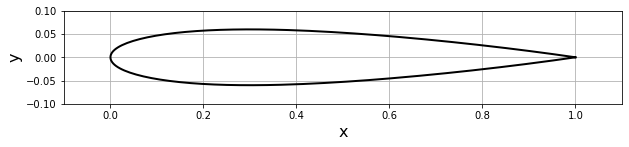

In [3]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

In [4]:
# discretize geoemetry into panels
panels = fd.define_panels(x, y, N=40)

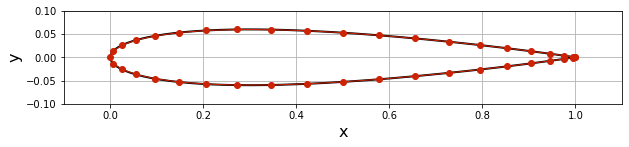

In [5]:
# plot discretized geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

Here we define some kinematic parameters that follow the midline of a fish backbone. We use the **Carangiform(w, k, A_n, A_t, x_pivot, total_length)** function in the `fish_kinematics.py` script. The Carangiform class expects a angular frequency **w**, body wave number **k**, the amplitude of the nose and tail **A_n, A_t** and assumes the amplitude at the pivot point is 0. It also requires the position of the pivot point along the body **x_pivot** and the total length of the fish.

In [6]:
total_length = 1.0
velocity = 0.3478
WL = 2.5*total_length         # body wavelength [m]
k = 2*np.pi/WL                # wave number [radians/meter]
freq = 2.47                   # flapping frequency [Hz]
strouhal = 1.136               
A_t = velocity*strouhal/freq    # tail beat amplitude [m]
A_n = 0.01275/total_length
w = 2*np.pi*freq                # angular frequency [radians/sec]                                                         
x_pivot = 0.7                   # pivot in percent of body length

midline = fk.Carangiform(w, k, A_n, A_t, x_pivot, total_length)
time = np.linspace(0, 1/freq, 8)

We discretize the time for 1 flap of the tail. Now we update the curvature of the airfoil and the panels and visualize the results.

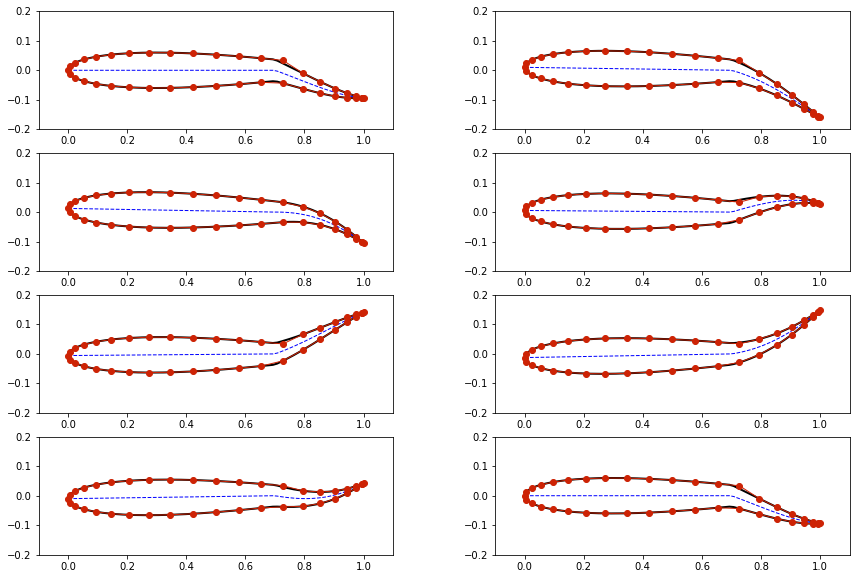

In [7]:
nrows = int(math.ceil(len(time) / 2.))
fig, axs = plt.subplots(nrows, 2,figsize=(15,10))
for ax, t in zip(axs.flat, time):
    panel_copy = copy.deepcopy(panels)
    for panel in panel_copy:
    # updates the panel position with time
        panel.update_position([0, 0], midline.single_rigid_motion(np.array([panel.xa, panel.xb]), t))
    
    h_foil = midline.rigid_motion(dx, t)
    y_new = np.append(np.flipud(h_foil), h_foil[1:-1])
    ax.plot(x, y + y_new, color='k', linestyle='-', linewidth=2)
    ax.plot(dx, h_foil, color='b', linestyle='--', linewidth=1)
    ax.plot([panel.xa for panel in panel_copy], [panel.ya for panel in panel_copy],
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.2, 0.2])